In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config


In [2]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()
df_tgt_ct.set_index(pd.DatetimeIndex(df_tgt_ct['ds']),inplace=True)
df_tgt_ct = df_tgt_ct.drop('ds',axis=1).resample('M').mean()

In [3]:
y = df_tgt_ct.y[:-20]
y_val = df_tgt_ct[-20:]

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_result = seasonal_decompose(y, model="multiplicative")

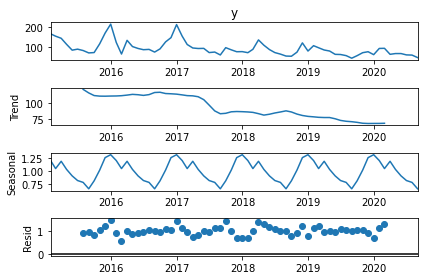

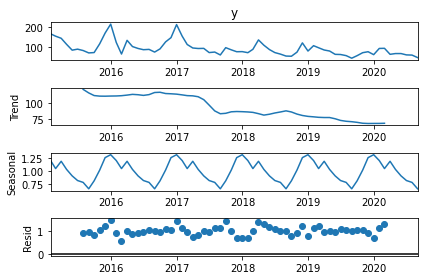

In [23]:
decompose_result.plot()

In [4]:
# 一次
fit = SimpleExpSmoothing(y).fit(optimized=True)

In [5]:
fit.summary()

Dep. Variable:,y,No. Observations:,68
Model:,SimpleExpSmoothing,SSE,51001.598
Optimized:,True,AIC,454.167
Trend:,None,BIC,458.606
Seasonal:,None,AICC,454.802
Seasonal Periods:,None,Date:,"Fri, 20 May 2022"
Box-Cox:,False,Time:,14:47:11
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,165.29956,l.0,True


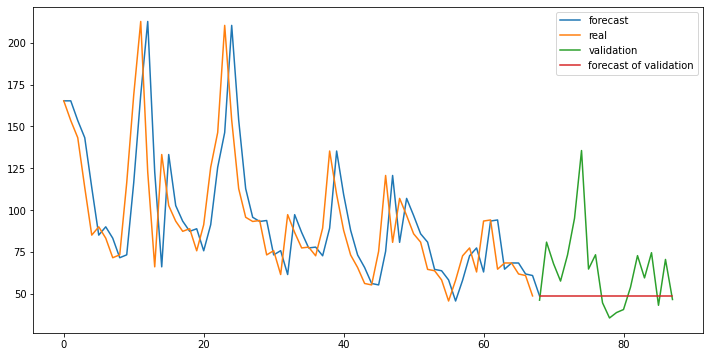

In [6]:
idx = list(range(len(df_tgt_ct)))
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()

In [15]:
fit2 = ExponentialSmoothing(y, seasonal_periods=4, trend='add', seasonal='add', use_boxcox=True,damped_trend=True).fit(optimized=True)

In [16]:
fit2.summary()

Dep. Variable:,y,No. Observations:,68
Model:,ExponentialSmoothing,SSE,55575.889
Optimized:,True,AIC,474.008
Trend:,Additive,BIC,493.983
Seasonal:,Additive,AICC,478.722
Seasonal Periods:,4,Date:,"Fri, 20 May 2022"
Box-Cox:,True,Time:,14:51:15
Box-Cox Coeff.:,-0.68532,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
smoothing_trend,0.000000,beta,True


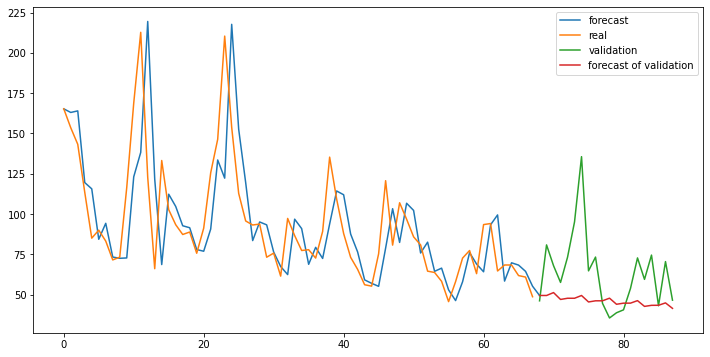

In [17]:
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit2.fittedfcast,index = idx[:len(fit.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit2.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()

In [10]:
fit3 = Holt(y, exponential=True, damped_trend=True).fit(optimized=True)

In [11]:
fit3.summary()

Dep. Variable:,y,No. Observations:,68
Model:,Holt,SSE,48794.582
Optimized:,True,AIC,457.159
Trend:,Multiplicative,BIC,468.256
Seasonal:,None,AICC,459.026
Seasonal Periods:,None,Date:,"Fri, 20 May 2022"
Box-Cox:,False,Time:,14:47:12
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9946800,alpha,True
smoothing_trend,0.0004435,beta,True


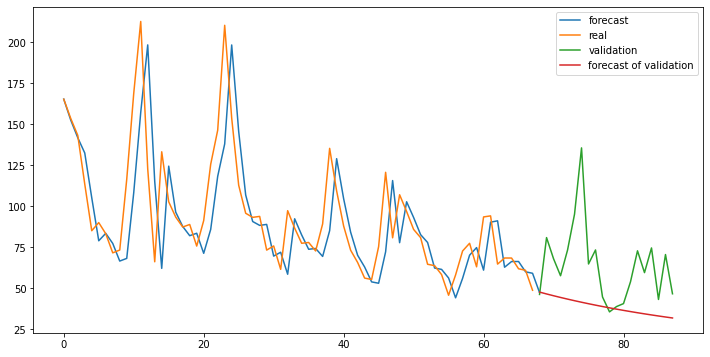

In [12]:
plt.figure(figsize=(12,6))
plt.plot(pd.Series(fit3.fittedfcast,index = idx[:len(fit3.fittedfcast)]),label = 'forecast')
plt.plot(pd.Series(y.values,index = idx[:len(y)]),label='real')
plt.plot(pd.Series(y_val.values.flatten(),index = idx[-len(y_val):]),label='validation')
plt.plot(pd.Series(fit3.forecast(len(y_val)).values.flatten(),index=idx[-len(y_val):]),label='forecast of validation')
plt.legend()
plt.show()

In [13]:
fit3.params

{'smoothing_level': 0.9946800439659665,
 'smoothing_trend': 0.0004435130849835922,
 'smoothing_seasonal': nan,
 'damping_trend': 0.9859528953513973,
 'initial_level': 179.40373865468942,
 'initial_trend': 0.9347581566224311,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}